# Image-Based Structural Analysis
### Code created and maintained by Justin David Q. SAN JUAN, <br>email: jdsanjuan@connect.ust.com, <br> personal website: justinsj.wixsite.com/portfolio

#### This code includes an example of the complete project pipeline as described below:
<img src="https://justinsj.weebly.com/uploads/6/4/9/2/64923303/process-flowchart_orig.jpg" alt="Drawing" style="width: 800px;"/>

# Import Dependencies
#### Dependencies:
numpy: for handling data types (mostly handled as numpy arrays)<br>
Sequential (from keras.models): for CNN setup<br>
random: for pseudo-random shuffling of data<br>
cv2: for raw RBG image import and transformation to grayscale<br>
time: for measuring time elapsed per function<br>
##### Custom Classes:
ImagePreprocessing: for binarizing image<br>
ComponentSegmentation: for proposing regions of interest (RoI's)<br>
ExtractionPreprocessing: for trimming, noise removal, and resizing of image<br>
ComponentClassifierTraining: for loading the CNN model, training data, and training the model<br>
ComponentClassifierPredict: for using the CNN model to predict the class of preprocessed extractions<br>
<br>
print_image_bw is used to print a simple 2-D array<br>
plot_model_results_and_save is used to display bounding boxes and corresponding predictions<br>
<br>
FEM_3 is used to reconstruct system and produce graphs<br>
<br>

In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import numpy as np
from keras.models import Sequential
import random
import cv2
import time

from image_preprocessing import ImagePreprocessing
from component_segmentation import ComponentSegmentation
from extraction_preprocessing import ExtractionPreprocessing
from component_classifier_training import ComponentClassifierTraining
from component_classifier_predict import ComponentClassifierPredict


from helper_functions import print_image_bw
from helper_functions import plot_model_results_and_save

from FEM_3 import produce_graphs


print('Done Importing...')

c:\users\jdqsj\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Done Importing...


# Hyper-parameters
#### Selective Search Parameters:
scale_input<br>
sigma_input<br>
min_size_input<br>
#### Noise Reduction Parameters:
min_shape: for minimum number of black pixels in bounding box<br>
min_height: for minimum height of bounding box<br>
min_width: for minimum width of bounding box<br>
<br>
buffer_zone: for expanding bounding box all directions<br>
min_area: for minimum area of bounding box<br>
min_black: for minimum number of black pixels in bounding box<br>
min_black_ratio: for minimum ratio of black pixels to the bounding box area<br>
#### Overlap Parameters:
overlap_repeats: for number of iterations for merging algorithm to be applied<br>
overlap_threshold: threshold of area intersection over union (IoU) area for merging to be applied<br>
overlap_threshold_small: maximum IoU for merging of small objects (IoU smaller than this is not merged)<br>
#### Removing Unconnected Pieces Parameters:
max_piece_percent: maximum percentage of piece to be removed<br>
(if percentage is larger, piece will not be removed as it is more likely an important piece)<br>
#### Extractions Preprocessing Parameters:
img_rows, img_cols: for classifier input shape<br>
wanted_w, wanted_h: for black pixels edges resizing boundary shape<br>
export_w, export_h: for overall image resizing shape ([export_w-wanted_w]/2 = horizontal buffer on each side)<br>
#### CNN Training Parameters:
num_classes: number of classes for classifier to predict<br>
TRAINING_RATIO_TRAIN: ratio of training samples to total number of samples<br>
TRAINING_RATIO_VAL: ratio of validation samples to total number of samples<br>
TRAINING_RATIO_TEST: ratio of test samples to total number of samples <br>
Note: TRAINING_RATIO_TEST is implicitly calculated as [1-{TRAINING_RATIO_TRAIN + TRAINING_RATIO_VAL}]<br>
dropout: dropout value to be used in all layers except last layer of Sketch-A-Net CNN model<br>
#### CNN Prediction Parameters:
min_percent_match: minimum probability of class prediction for that class to be set as the prediction<br>
min_confidence: minimum difference between first-highest % match and second-highest % match<br>
(higher difference means less ambiguity between first and second highest match, which means less likelihood of random object)<br>
##### The directory is also defined in the PATH variable.<br>The name of the CNN model data is defined in the name variable.<br>The training data set name for the CNN is defined in the data_set_name variable.

In [2]:
#selective search parameters
scale_input=200 #200 previous: #10
sigma_input=15 #10 previous: #15
min_size_input=10 #10 previous: #5

#noise reduction parameters
min_shape=40 #min. number of black pixels  
min_height=5 #min. height of bounding box
min_width=5 #min. width of bounding box

buffer_zone=2 #expand bounding box by this amount in all directions  
min_area=60 #min. area of bounding box
min_black=5 #min. number of black pixels
min_black_ratio=0.01 #min ratio of black pixels to the bounding box area

#Overlap parameters
overlap_repeats = 2 #set to 8
overlap_threshold = 0.3 #set to 0.3 (overlap has to be larger than the threshold)
overlap_threshold_small = 0.3 #max IoU for small overlap

#Removing unconnected pieces parameters
max_piece_percent=0.3  # set to 0.3

#Extractions preprocessing paramaters
img_rows, img_cols = 100,100
wanted_w, wanted_h, export_w, export_h = img_cols, img_rows, img_cols, img_rows

#CNN training parameters
num_classes = 64
TRAINING_RATIO_TRAIN = 0.7
TRAINING_RATIO_VAL = 0.15
#TRAINING_RATIO_TEST = 0.15 implicitly
dropout = 0

#CNN prediction parameters
min_percent_match = 0.7 # set to 0.7
min_confidence = 0.3 # set to 0.3

#Time Cost parameters
time_cost_string_list = ['Loading image','Component Segmentation','Extraction Preprocessing',
                         'Component Classifier Training','Component Classifier Predict',
                        'Printing Results','System Reconstruction','Acquiring and Printing Ground Truth Data',
                        'Data Concatenation & Cleaning','Data Control, Counting, & Training from Multiple Files',
                        'Testing','Printing Confusion Matrix']
time_cost_time_list = np.zeros(len(time_cost_string_list)).astype(np.int).tolist()

#Paths and names
PATH = 'D:/Desktop/HKUST/ISA/Code as of 2019-02-26/DEPENDENCIES/' #must have "/" at the end

model_name = 'Sketch-A-Net_controlled_600_30858_7_layers'

base_dataset_name = 'Training_Samples_64_classes_100x100_all'

dataset_PATH = PATH
dataset_name = 'Training_Samples_64_classes_100x100_all_cleaned_32898'

new_dataset_name = 'Training_Samples_64_classes_100x100_all_cleaned_32898'

print('Done setting hyperparamters...')

Done setting hyperparamters...


# Load Image
Image (binary, grayscale, 2D, numpy array) for regions of interest proposals is loaded.

Loading image: D:/Desktop/HKUST/ISA/ForISA/Q0050V0004S7.jpg


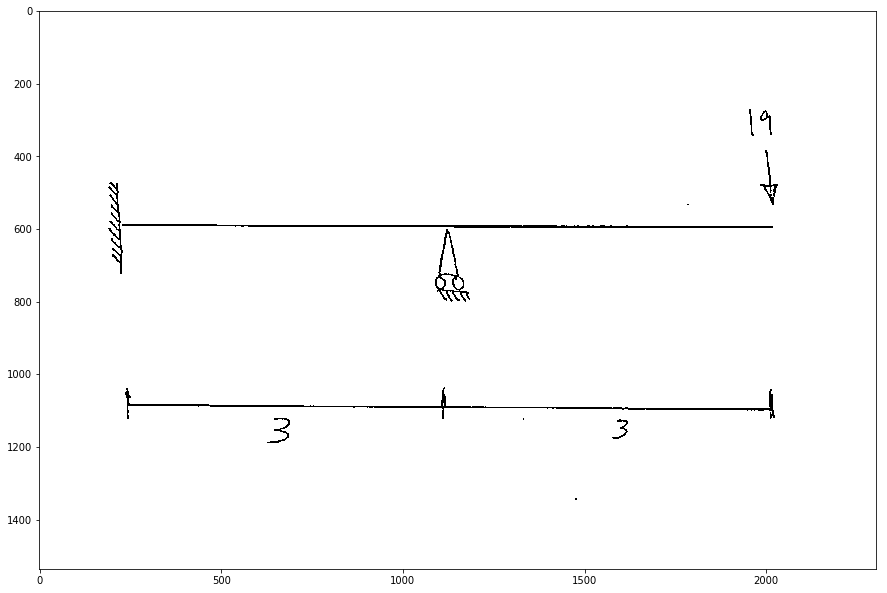

In [3]:
image_name = 'Q0050V0004S7.jpg'
test_path = 'D:/Desktop/HKUST/ISA/ForISA/'
ImgLoader = ImagePreprocessing()
image = ImgLoader.load_image(test_path+image_name,1.4)

l,w = 15,15 #dimension scales of print
print_image_bw(image,l,w)

# Component Segmentation
##### Using the ComponentSegmentation class:
    1. Selective Search is applied to the image (to generate bounding boxes)
    2. A merging algorithm is applied to the selective search bounding boxes (to merge highly overlapping bounding boxes)
##### The ComponentSegmentation uses the following data for initialization:
    - image: binary (grayscale) 2-D array for region proposal
    - model_name: for unique prints saving
    - min_shape, min_height, min_width, buffer_zone, min_area, min_black, min_black_ratio: for noise reduction
    - overlap_repeats, overlap_threshold: for merging algorithm
##### Then, the RoI proposal is done using the custom search method, which uses the selective search hyper-parameters:
    - scale_input
    - sigma_input
    - min_size_input
##### Then, the merging algorithm is applied within the search function, and a merged_set is retrieved.

Premerged Set


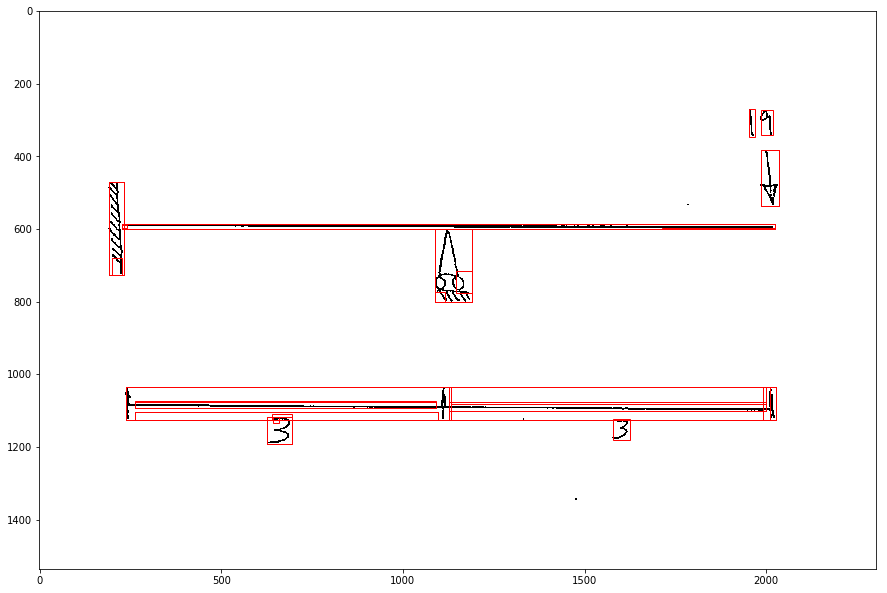

Merged Set


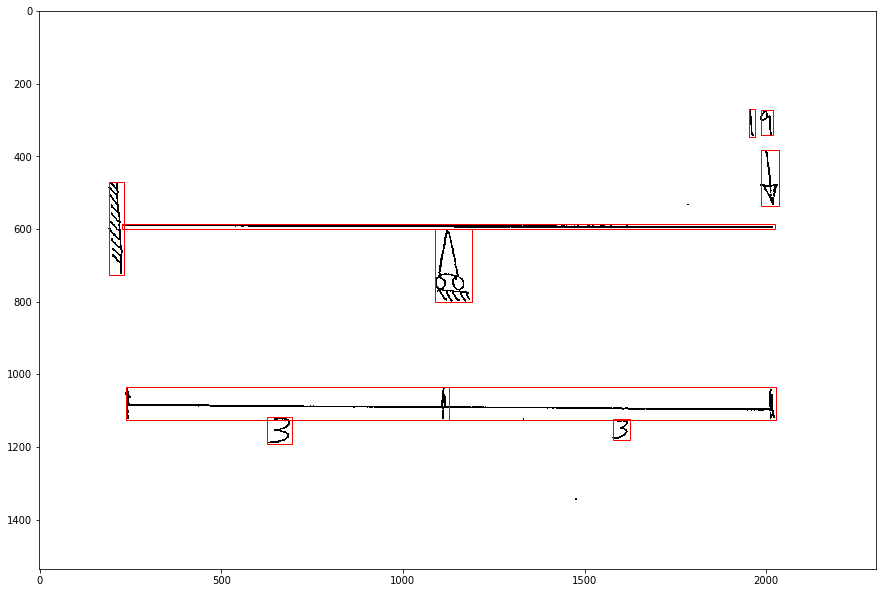

In [4]:
#Create object ComponentSegmentation, which will use the search function to perform segmentation and merging.
segmentation_obj = ComponentSegmentation(image, model_name, min_shape, min_height, min_width, buffer_zone, min_area, min_black, min_black_ratio, overlap_repeats, overlap_threshold, overlap_threshold_small)
segmentation_obj.search(scale_input, sigma_input, min_size_input) # run search (segmentation code)
merged_set = segmentation_obj.merged_set

# ExtractionPreprocessing
#### Merged set from ComponentSegmentation is passed to ExtractionPreprocessing and the following is applied:
    1. Trim: extra space around the farthest black pixels are removed
    2. Remove Unconnected Parts: extra pixels (from other components) captured by the bounding box are removed
    3. Trim: trimming again as empty spaces may be released
    4. Resize: extraction is resized to the prescribed 100x100 dimension using max pooling for downsampling to preserve data
ext_images_list = extraction images: list of 100x100 binary (grayscale) 2-D arrays<br>
ext_data_list = extraction data: list of x, y, w, h data of extractions bounding boxes<br> 
where:<br>
    - x, y: top-left corner coordinates of bounding box
    - w, h: width and height of bounding box respectively
#### The preprocess_extractions function is called and the extraction images and extraction data are acquired.
#### The plot_bounding_boxes_with_names function is then used to display the bounding boxes on the original image.

In [5]:
#Transport data into ExtractionPreprocessing class, which will trim, remove unconnected parts, then trim, and resize
extraction_obj = ExtractionPreprocessing(image, model_name, merged_set)

# Get 4 lists from preprocess_extractions function
ext_images_list, ext_data_list = extraction_obj.preprocess_extractions(wanted_w, wanted_h, export_w, export_h, max_piece_percent)

# ComponentClassifierTraining (pre-trained)
### If model has been trained before:
### Then we only need:
training_obj.model.load_weights(PATH+name+'.h5')
### Else, the other API calls are needed to shuffle_data, train, and save_weights.
##### The ComponentClassifierTraining object is first initialized with:
    - PATH: working directory
    - data_set_name: for loading training data set
    - num_classes, dropout: CNN model parameters
    - TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL: training parameters

In [6]:
training_obj = ComponentClassifierTraining(num_classes,TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL) #instantiate object
#Model is Sketch_a_net
training_obj.model = training_obj.load_sketch_a_net_model_7_layers(dropout, num_classes, (100,100,1)) #load the layers
training_obj.model.load_weights(dataset_PATH+model_name+'.h5') #load the actual weights
trained_model = training_obj.model #acquire model

# ComponentClassifierPredict
### The ComponentClassifierPredict object is first initialized with the entropy-based hyperparameters:
    - min_percent_match
    - min_confidence
These parameters were explained in the Hyperparameters section above.
### The predict_classes function produces the following:
    - ext_class_index_list: ordered list of highest % match class predictions for each
The entropy-based modifications are applied to the above (such that if any of the two criteria are not satisfied, the prediction is classified as random)
    - ext_class_name_list: ordered list of corresponding names to ext_class_index_list
    - ext_match_first_max_percent_list: ordered list of corresponding first-highest match percentage
    - ext_match_second_max_percent_list: ordered list of corresponding second-highest match percentage

In [7]:
predictor = ComponentClassifierPredict(min_percent_match, min_confidence) #get predictor
 
ext_class_index_list, ext_class_name_list, \
ext_match_first_max_percent_list, ext_match_second_max_percent_list = \
predictor.predict_classes(ext_images_list,trained_model)

# Printing Results
#### Results are plotted on the original image using:
    - image: for background
    - model_name: for saving
    - ext_data_list: list of x, y, w, h coordinates for each bounding box
    - ext_class_index_list: list of predicted class indices
    - ext_class_name_list: list of corresponding class names per predicted index
    - ground_truth_index_list: list of ground truth class indices (currently set as the predicted classes.)*
##### Each bounding box is labelled with two items separated by a colon:
    - First: index of that object in the full list.
    - Second: predicted class name of that object.
##### If the predicted class matches with the ground truth class, <br> then the predicted label is coloured green, otherwise it is red. <br> * For this example, the ground truth labels were set as the predicted classes, so all labels are green.

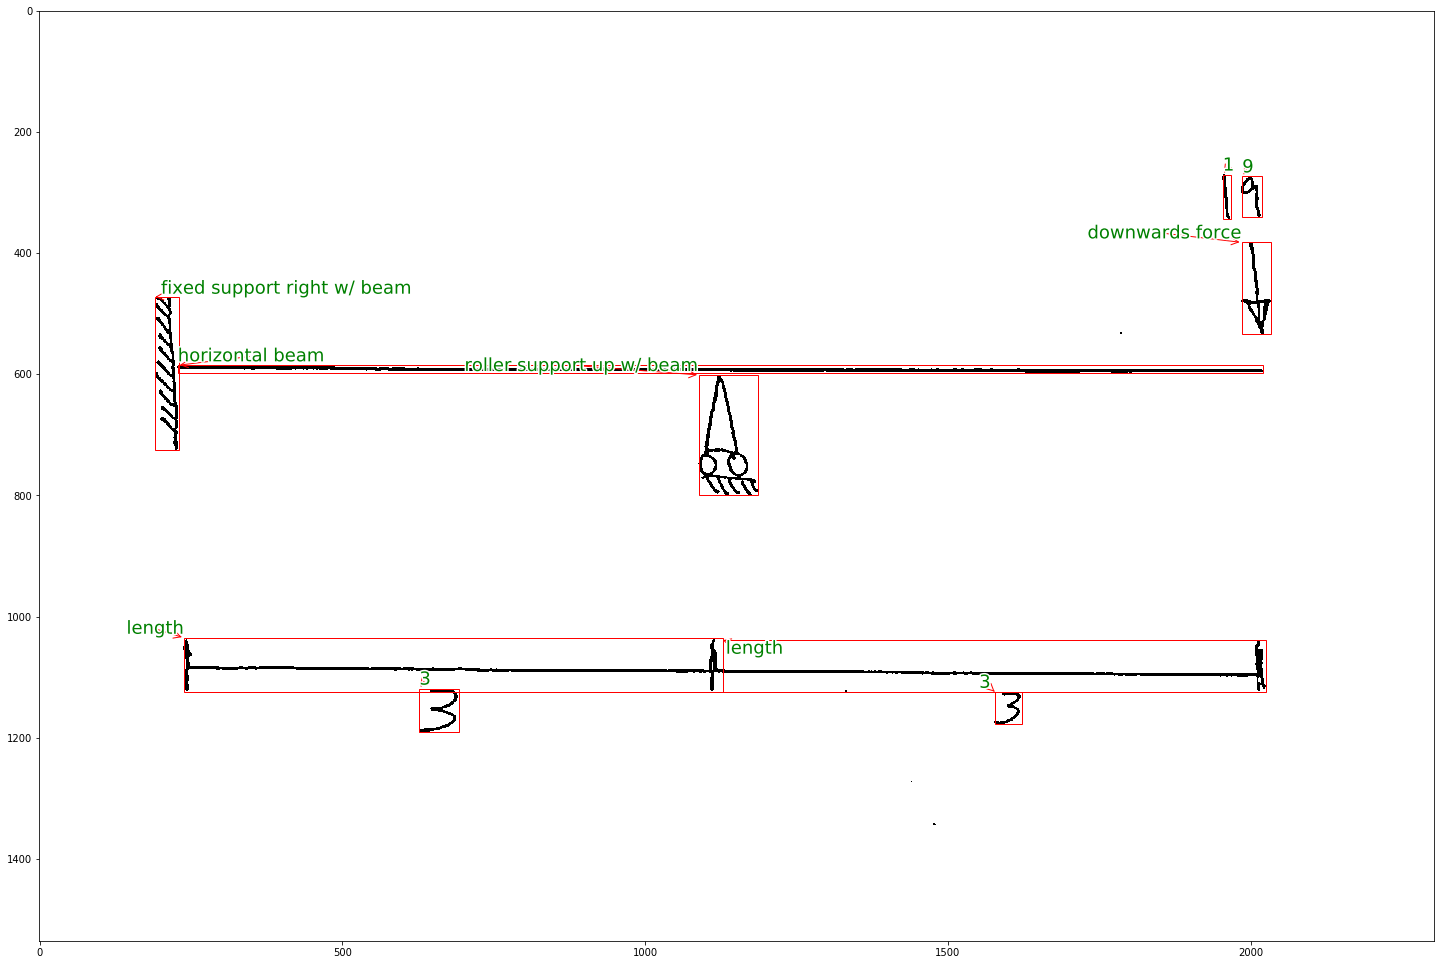

saving: D:/Desktop/HKUST/ISA/ForISA/GT_Q0050V0004S7.txt


In [8]:
ground_truth_index_list = ext_class_index_list # set all answers as correct answers for now


plot_model_results_and_save(image,model_name, ext_data_list, ext_class_index_list, 
                            ext_class_name_list, ground_truth_index_list,
                            m1_percent_list=ext_match_first_max_percent_list, 
                            m2_percent_list=ext_match_second_max_percent_list, 
                            show_percentages = False,print_extra_indices=False, 
                            show_annotations = True,
                            rejected_classes = [22,23])

# System Reconstruction

loading: D:/Desktop/HKUST/ISA/ForISA/GT_Q0050V0004S7.txt


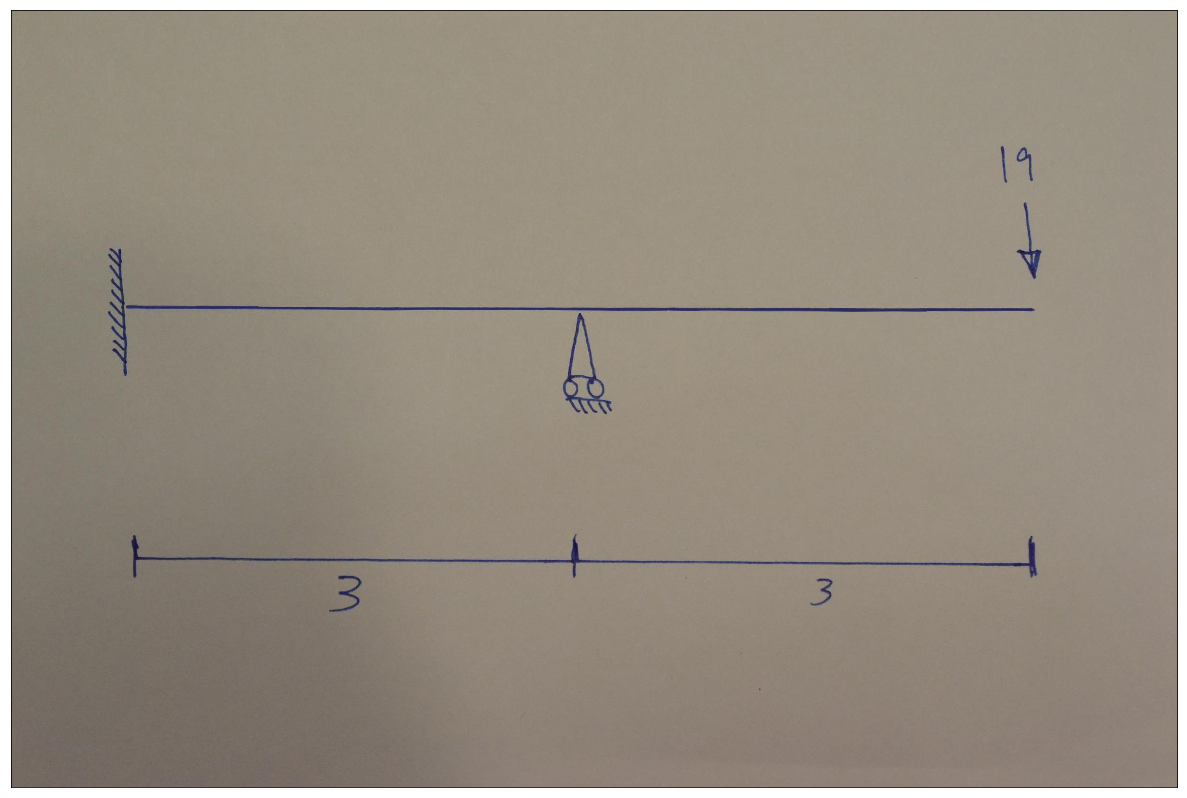

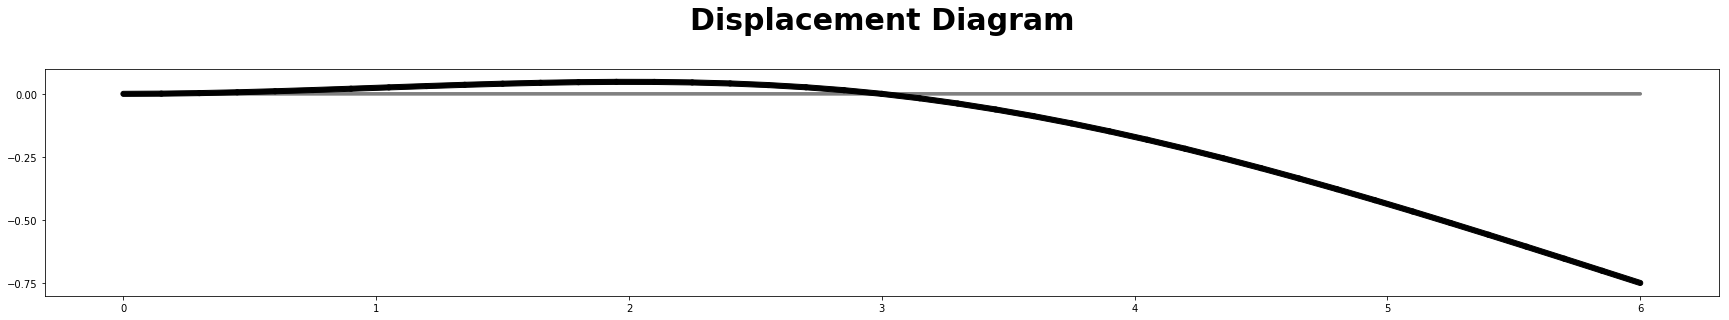

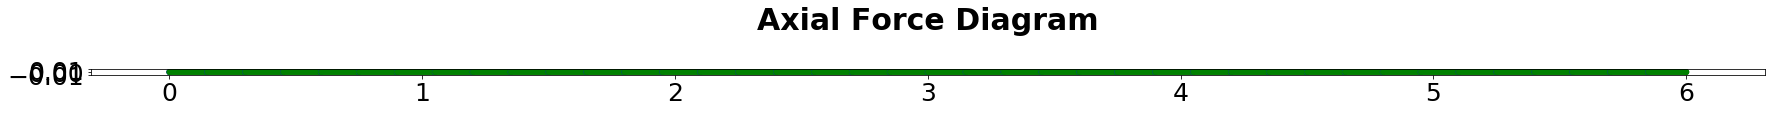

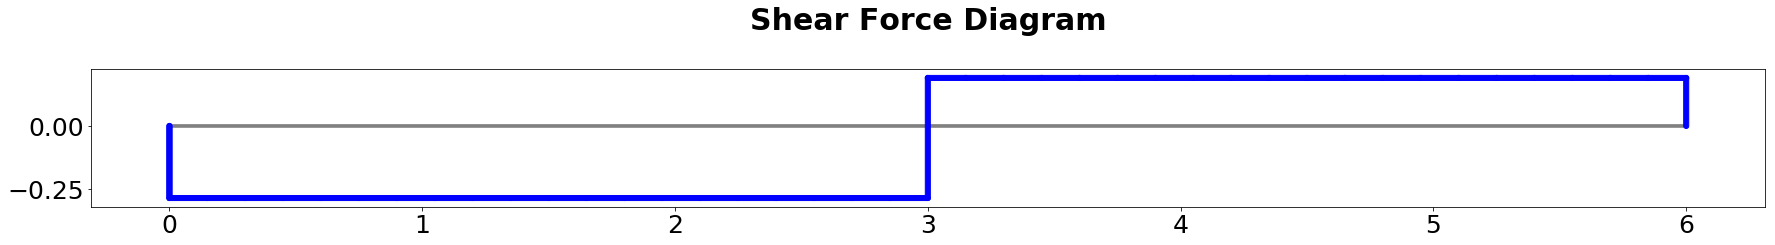

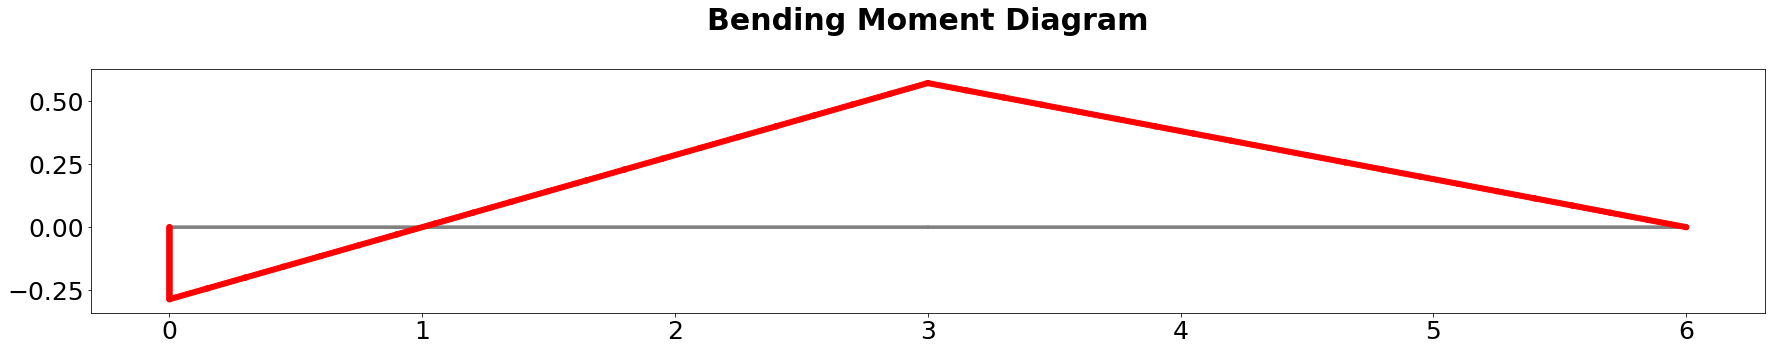

In [9]:
produce_graphs(test_path, image_name.split(".")[0],20)